## 一、SUM函数中axis=1在三维时运算

In [3]:
import torch
A = torch.tensor([[[ 1,  2,  3,  4,  5],
                   [ 6,  7,  8,  9, 10],
                   [11, 12, 13, 14, 15],
                   [16, 17, 18, 19, 20]],
                  
                  [[21, 22, 23, 24, 25],
                   [26, 27, 28, 29, 30],
                   [31, 32, 33, 34, 35],
                   [36, 37, 38, 39, 40]],
                  
                  [[41, 42, 43, 44, 45],
                   [46, 47, 48, 49, 50],
                   [51, 52, 53, 54, 55],
                   [56, 57, 58, 59, 60]]])
print(A.shape)  # 输出 torch.Size([3, 4, 5])


torch.Size([3, 4, 5])


In [4]:
sum_result = torch.sum(A, axis=1)
print(sum_result)
print(sum_result.shape)  # 输出结果的形状

tensor([[ 34,  38,  42,  46,  50],
        [114, 118, 122, 126, 130],
        [194, 198, 202, 206, 210]])
torch.Size([3, 5])


说明：对于3维的张量，其axis=1，是对第二维（行）进行运算，那么就可以理解为，对于同一通道，同一列，不同行进行运算

In [6]:
sum_result = torch.sum(A, axis=1,keepdims=True)
print(sum_result)
print(sum_result.shape)  # 输出结果的形状

tensor([[[ 34,  38,  42,  46,  50]],

        [[114, 118, 122, 126, 130]],

        [[194, 198, 202, 206, 210]]])
torch.Size([3, 1, 5])


keepdims=True 可以保留维度，不会对数据进行降维

In [8]:
sum_result1=torch.sum(A)
sum_result1

tensor(1830)

In [9]:
type(sum_result1)

torch.Tensor

In [10]:
type(sum_result)

torch.Tensor

## 二、自动微分

In [12]:
import torch
x=torch.arange(4.0,requires_grad=True)
print(x.grad)

None


梯度的默认值是0

In [14]:
y=2*torch.dot(x,x)
y.backward()  #反向传播函数
x.grad

tensor([ 0.,  4.,  8., 12.])

In [15]:
y1=sum(x)
y1.backward()
x.grad

tensor([ 1.,  5.,  9., 13.])

梯度会累加，正确的做法是对梯度进行清零

In [17]:
x.grad.zero_()

tensor([0., 0., 0., 0.])

In [18]:
x.grad

tensor([0., 0., 0., 0.])

In [19]:
y=sum(x)
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [20]:
x.grad.zero_()
y=x*x
y.backward(torch.ones_like(y))
x.grad

tensor([0., 2., 4., 6.])

如果y不是标量，那么y.backward()中要传入一个torch.ones_like(y)这个参数

In [22]:
x.grad.zero_()  
y=x*x  
u = y.detach() #将y进行分离，在计算z关于x的梯度时，将y视为常数
z=u*x  
z.backward(torch.ones_like(z))  

## 三、概率

In [24]:
%matplotlib inline  
import torch  
from torch.distributions import multinomial   # 用于多项式分布抽样
from d2l import torch as d2l

In [25]:
fair_probs = torch.ones([6]) / 6 
# fair_probs 设定公平骰子的概率分布，6个面，每个面出现的概率是 1/6
fair_probs

tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])

In [26]:
# 使用多项分布模拟 500 次实验，每次实验有 10 次投骰子，fair_probs 是骰子面朝上的概率
counts = multinomial.Multinomial(10, fair_probs).sample((500,))  
counts

tensor([[1., 3., 3., 2., 0., 1.],
        [5., 1., 1., 2., 1., 0.],
        [1., 1., 3., 2., 2., 1.],
        ...,
        [0., 1., 0., 5., 3., 1.],
        [1., 4., 2., 0., 3., 0.],
        [0., 3., 3., 1., 1., 2.]])

In [27]:
# dim=0，以列的维度进行累加cumsum
cum_counts = counts.cumsum(dim=0)
cum_counts

tensor([[  1.,   3.,   3.,   2.,   0.,   1.],
        [  6.,   4.,   4.,   4.,   1.,   1.],
        [  7.,   5.,   7.,   6.,   3.,   2.],
        ...,
        [852., 825., 841., 798., 799., 865.],
        [853., 829., 843., 798., 802., 865.],
        [853., 832., 846., 799., 803., 867.]])

In [28]:
# 计算每种点数出现的估计概率，估计概率是当前累计次数除以当前试验的总次数
#  dim=1,对行的维度进行求和，keepdims=True表示不进行降维，那么行这个维度可以保留
fenmu=cum_counts.sum(dim=1, keepdims=True)  
print(fenmu.shape)
estimates = cum_counts / fenmu
estimates#每次实验后，摇到每个点正面概率

torch.Size([500, 1])


tensor([[0.1000, 0.3000, 0.3000, 0.2000, 0.0000, 0.1000],
        [0.3000, 0.2000, 0.2000, 0.2000, 0.0500, 0.0500],
        [0.2333, 0.1667, 0.2333, 0.2000, 0.1000, 0.0667],
        ...,
        [0.1711, 0.1657, 0.1689, 0.1602, 0.1604, 0.1737],
        [0.1709, 0.1661, 0.1689, 0.1599, 0.1607, 0.1733],
        [0.1706, 0.1664, 0.1692, 0.1598, 0.1606, 0.1734]])

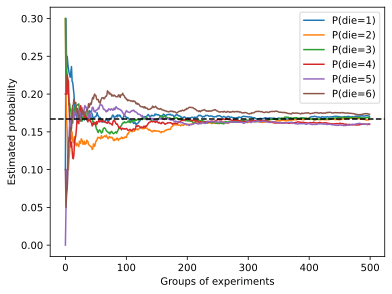

In [29]:
d2l.set_figsize((6, 4.5))  
# 循环画出每个点数的估计概率曲线
for i in range(6):  
    # estimates[:, i] 提取第 i 列，即第 i 个点数的概率估计值
    d2l.plt.plot(estimates[:, i].numpy(),  label=("P(die=" + str(i + 1) + ")"))  #numpy将tensor转化成narrary
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')  
d2l.plt.gca().set_xlabel('Groups of experiments')  
d2l.plt.gca().set_ylabel('Estimated probability')  
d2l.plt.legend();